# The Challenge

In the first tutorial we learned about heatmaps as a different way of presenting the same information that we would normally plot using lines. In the second tutorial we learned how to delete, move, and add graphic elements to make our visualizations simpler, more effective, and more beautiful. Now we want to apply those skills and try to reproduce a real-world example.

The Financial Times (FT) has done an amazing job creating [interactive visualizations](https://ig.ft.com/coronavirus-chart/) to keep track of the evolution of cases and deaths due to COVID-19 in the world and the US. We are going to focus on a less popular, but not less effective, visualization of restrictions and lockdowns due to COVID-19. In case you can't visit [the website](https://ig.ft.com/coronavirus-lockdowns/), here's a screenshot:

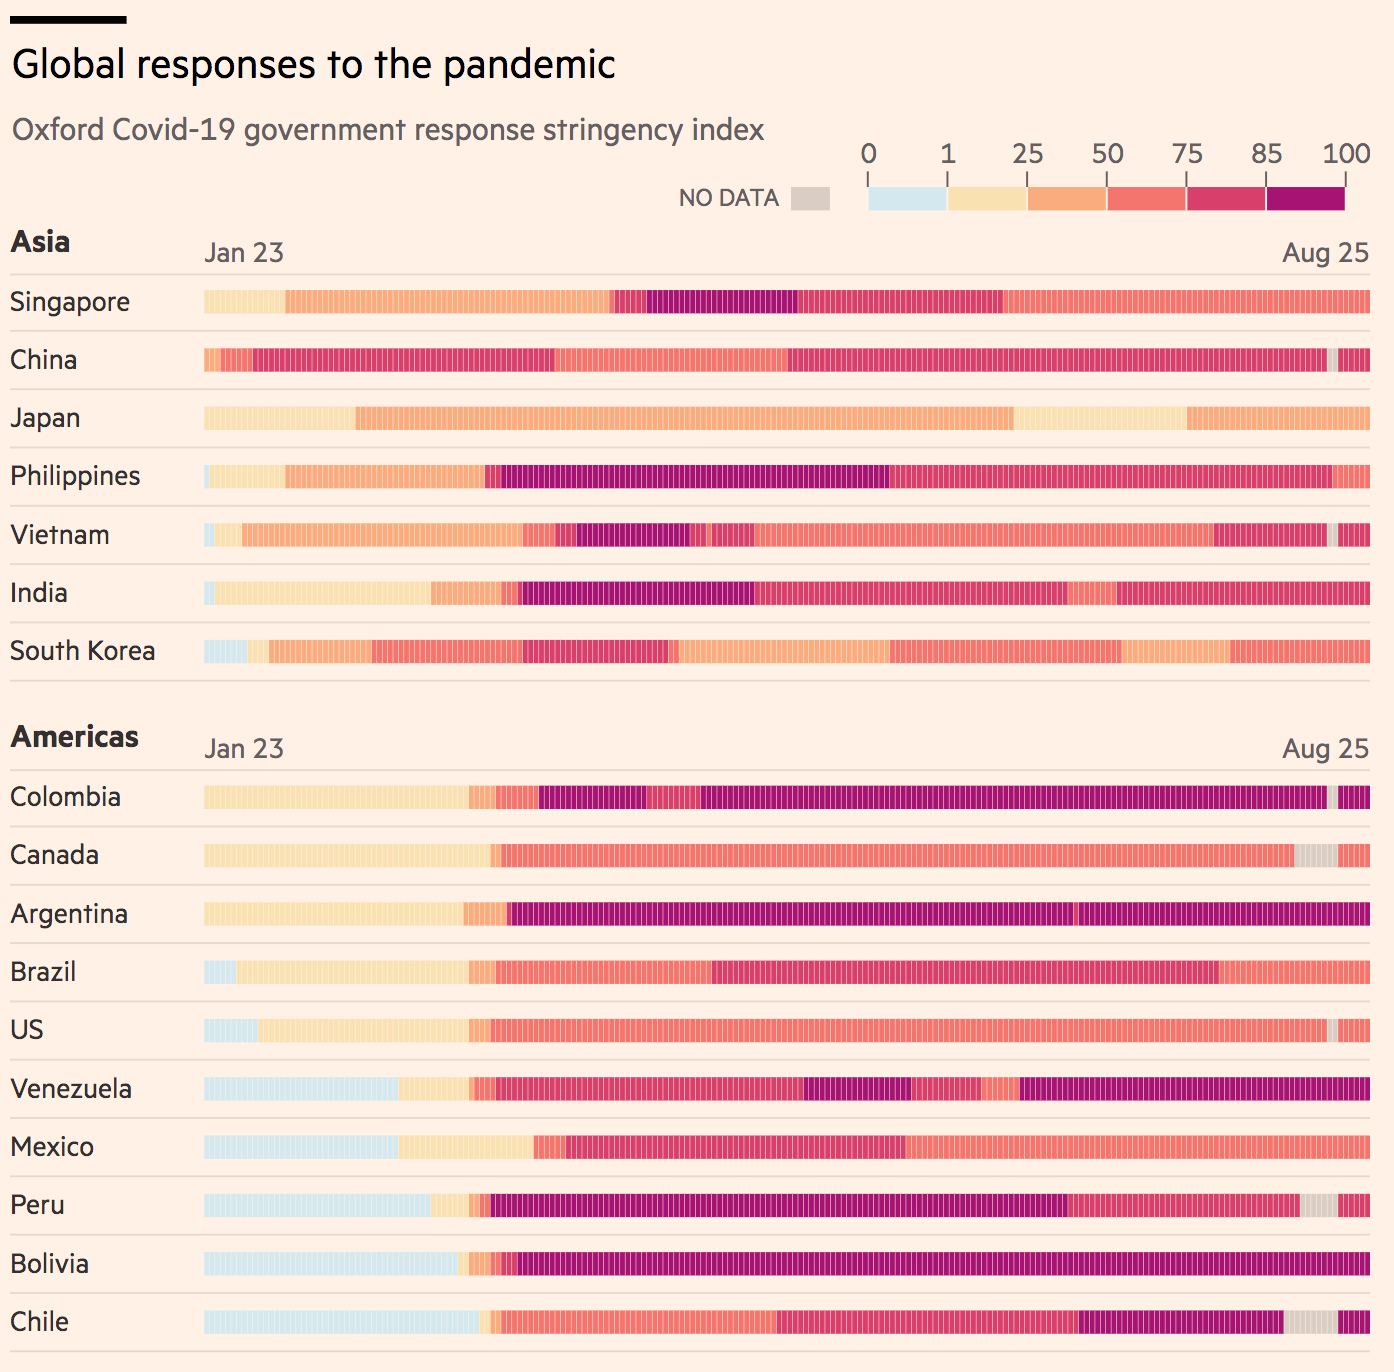

In [2]:
from IPython.display import Image
Image("ft-lockdowns.png", width=800)

**What Python routine/method/technique would you use to reproduce this?**

To me, that looks like a heatmap and a lot of simplify and beautify.

# The data

The FT uses data from the Oxford Covid-19 Government Response Tracker, which is publicly availabe on their GitHub repo.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

In [10]:
path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
grt = pd.read_csv(path, index_col='Date')
grt.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CountryName,CountryCode,RegionName,RegionCode,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
Date,,,,,,,,,,,,,,,,,,,,,
20200101,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200102,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200103,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200104,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20200105,Aruba,ABW,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Two important things we need to pay attention to: (i) there's a lot of information in the dataset that we won't use, and (ii) we need the dataset in a format that would be easier to plot with seaborn. Data preprocessing usually takes a huge amount of time, but in this case I'll do that for you. I'll choose all the South American countries, although you are free to choose different countries.

In [12]:
df = pd.DataFrame()
countries = ['Chile', 'Argentina', 'Bolivia', 'Brazil', 'Colombia', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela']
for country in countries:
    rename = grt.rename({'StringencyIndex': country}, axis=1)
    filtered = rename['CountryName'] == country
    df[country] = rename[filtered][country]
df = df.replace(0, np.nan)
df = df.T
df.head()

Date,20200101,20200102,20200103,20200104,20200105,20200106,20200107,20200108,20200109,20200110,...,20200821,20200822,20200823,20200824,20200825,20200826,20200827,20200828,20200829,20200830
Chile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.80,83.80,83.80,83.80,83.80,83.80,83.80,NaN,NaN,NaN
Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.96,87.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bolivia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89.81,89.81,89.81,89.81,NaN,NaN,NaN,NaN,NaN,NaN
Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.35,64.35,64.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.04,87.04,87.04,87.04,87.04,87.04,87.04,NaN,NaN,NaN


Additionally, here are some functions that could make your life easier when dealing with the colormap used by the FT.

In [37]:
def truncate_colormap(cmapIn='magma_r', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    return new_cmap

new_magma = truncate_colormap("magma_r", minval=0.1, maxval=0.8, n=100)
bounds = np.array([1, 25, 50, 75, 85, 100])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Your plot

This is the space where you get creative and apply everything we've learned so far! As motivation, I'll leave one plot created with seaborn that resembles the one from the FT. 

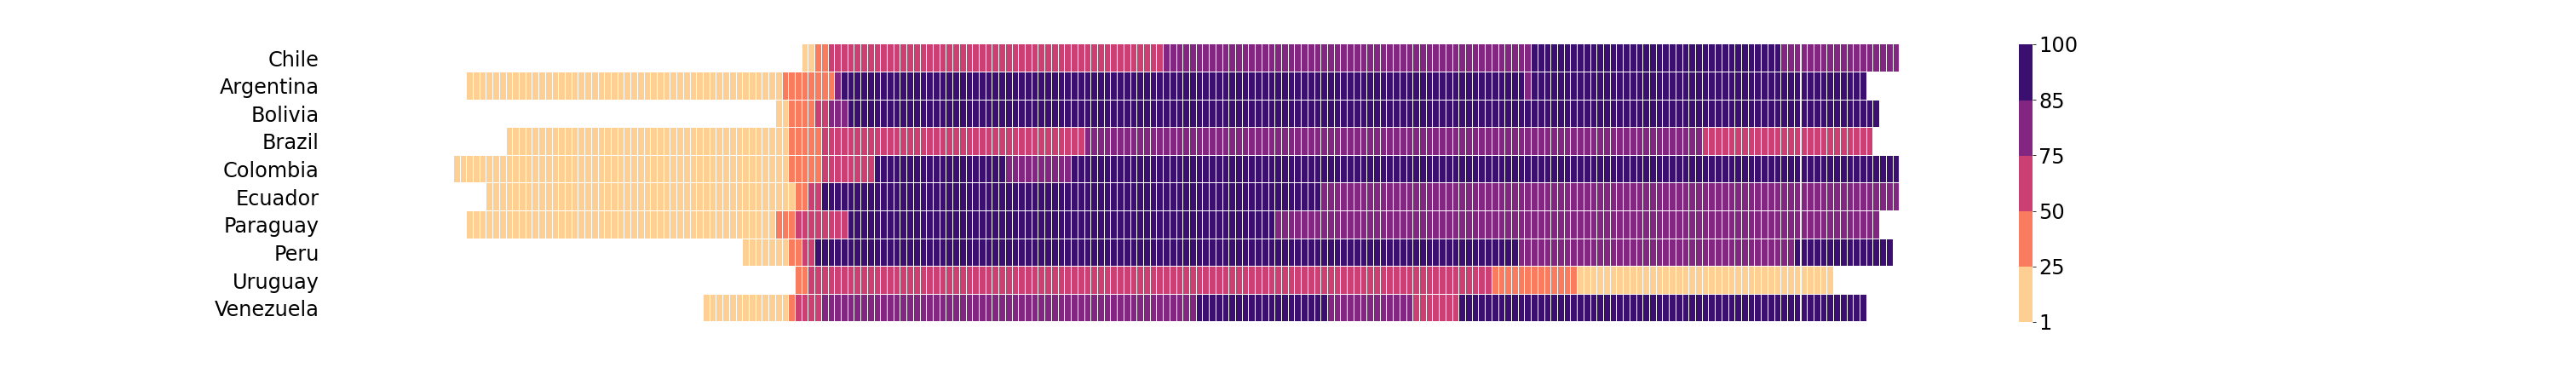

In [106]:
from IPython.display import Image
Image("ft-seaborn.png", width="100%")

Your code: